In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import intake
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38495,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:34877,Total threads: 1
Dashboard: /proxy/40279/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:39179,


In [3]:
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*ocean_month_z.nc'))
pathsMW = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*ocean_month_z.nc'))

#pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
#pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])

In [5]:
def preprocessC(control):
    control = control[['thetao', 'so']].sel(yh = slice(None, -55))
    return control

def preprocessMW(perturbation):
    perturbation = perturbation[['thetao', 'so']].sel(yh = slice(None, -55))
    return perturbation

control = xr.open_mfdataset(pathsC, preprocess = preprocessC)
perturbation = xr.open_mfdataset(pathsMW, preprocess = preprocessMW)

In [6]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",     
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [7]:
depth = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output030/20020101.ocean_static.nc')['deptho']
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

In [9]:
control_shelf = control.where(shelf_mask == 1)
perturbation_shelf = perturbation.where(shelf_mask == 1)

In [10]:
temp_anomaly = perturbation.thetao - control.thetao
salt_anomaly = perturbation.so - control.so

In [11]:
temp_shelf_anomaly = perturbation_shelf.thetao - control_shelf.thetao
salt_shelf_anomaly = perturbation_shelf.so - control_shelf.so

Next, we load cell area (denoted as $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely  

$A(z) = \sum_x \sum_y a(x,y,z)$

We load dxt and dyt and compute a masked version of cell area; we also use a slight hack to divide temperature by itself and thereby get a 3-dimensional cell area mask that is needed to create.

In [13]:
area = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output030/20020101.ocean_static.nc')['areacello']
total_area = area.cf.sum({'longitude', 'latitude'}).load()
shelf_area = area.where(shelf_mask == 1).cf.sum({'longitude', 'latitude'}).load()

Now, the mean temperature at each time level can then be computed as

$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \, \tilde{\theta}(x,y,z,t)}{A(z)}$

where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [14]:
#for loop here using yearlength chunks [for panan005, may not need for 01]

temp_hov = (area * temp_anomaly).cf.sum({'longitude', 'latitude'}) / total_area
salt_hov = (area * salt_anomaly).cf.sum({'longitude', 'latitude'}) / total_area

In [15]:
#For shelf
temp_shelf_hov = (area * temp_shelf_anomaly).cf.sum({'longitude', 'latitude'}) / shelf_area
salt_shelf_hov = (area * salt_shelf_anomaly).cf.sum({'longitude', 'latitude'}) / shelf_area

In [8]:
temp_hov = temp_hov.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 23.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [9]:
salt_hov = salt_hov.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 23.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [16]:
temp_shelf_hov = temp_shelf_hov.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 30.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [17]:
salt_shelf_hov = salt_shelf_hov.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 30.73 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [18]:
def plot_hovmoller(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize = (10, 6))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63]),
          fig.add_subplot(grid[32:, :30]), fig.add_subplot(grid[32:, 33:63])]
    
    for i in range(len(ax)):
        #ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

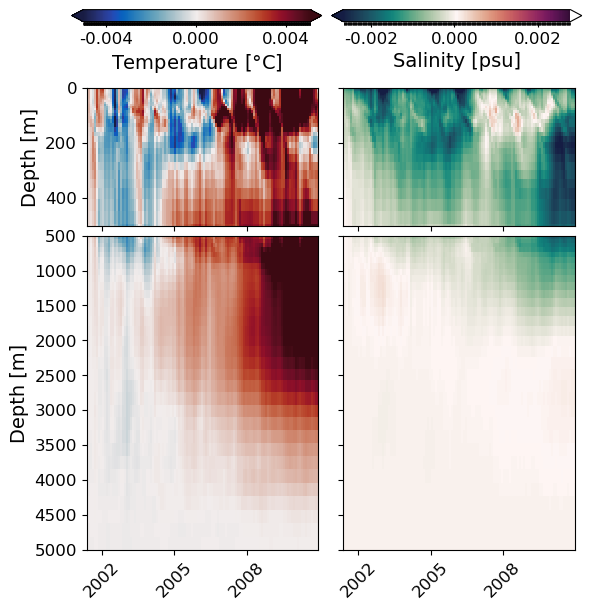

In [23]:
#All area plot

fig, ax = plot_hovmoller(fsize = 14)

levels_temperature = np.arange(-0.005, 0.0051, 0.00001)

cf_temp = temp_hov.cf.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'vertical',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

temp_hov.cf.plot(ax = ax[2],
                        levels = levels_temperature,
                        x = 'time',
                        y = 'vertical',
                        add_colorbar = False,
                        label = None,
                        cmap = cm.balance)

levels_salinity = np.arange(-0.002, 0.0021, 0.00001)

cf_salt = salt_hov.cf.plot(ax = ax[1],
                               levels = levels_salinity,
                               x = 'time',
                               y = 'vertical',
                               add_colorbar = False,
                               label = None,
                               cmap = cm.curl)

salt_hov.cf.plot(ax = ax[3],
                     levels = levels_salinity,
                     x = 'time',
                     y = 'vertical',
                     add_colorbar = False,
                     label = None,
                     cmap = cm.curl)

## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(500, 0)
        ax[i].set_xlim(500,4000)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel("")
        ax[i].set_xlim(500,4000)
        ax[i].set_ylim(5000, 500)
ax[0].set_ylabel("Depth [m]")
ax[1].set_ylabel("")
ax[2].set_ylabel("Depth [m]")
ax[3].set_ylabel("")



# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()

In [29]:
def plot_hovmoller_shelf(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize = (10, 9))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63])]
    
    for i in range(len(ax)):
        #ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

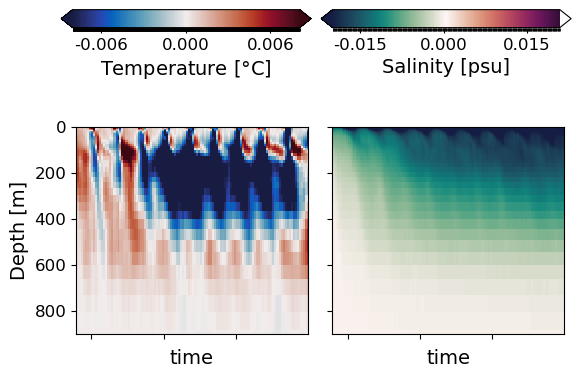

In [31]:
#Shelf area plot

fig, ax = plot_hovmoller_shelf(fsize = 14)

levels_temperature = np.arange(-0.008, 0.0081, 0.00001)

cf_temp = temp_shelf_hov.cf.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'vertical',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

levels_salinity = np.arange(-0.02, 0.021, 0.0001)

cf_salt = salt_shelf_hov.cf.plot(ax = ax[1],
                               levels = levels_salinity,
                               x = 'time',
                               y = 'vertical',
                               add_colorbar = False,
                               label = None,
                               cmap = cm.curl)

## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(900, 0)
        ax[i].set_xlim(500,4000)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel("")
        ax[i].set_xlim(500,4000)
        ax[i].set_ylim(5000, 900)
ax[0].set_ylabel("Depth [m]")
ax[1].set_ylabel("")


# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()